In [2]:
# --- 1. INSTALACIÓN DE LIBRERÍAS NECESARIAS ---
!pip install lxml pandas seaborn matplotlib

In [3]:
# --- 2. IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Arc, Circle
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path

In [4]:
# ---------------------------
# 3. Función para cargar datos
# ---------------------------
def cargar_datos_nacsport(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    data = []
    for instance in root.findall(".//instance"):
        jugador = instance.findtext("code")
        pos_x = [float(px.text) for px in instance.findall("pos_x")]
        pos_y = [float(py.text) for py in instance.findall("pos_y")]
        labels = [lbl.findtext("text") for lbl in instance.findall("label")]
        data.append({
            "jugador": jugador,
            "pos_x_list": pos_x,
            "pos_y_list": pos_y,
            "labels": labels
        })
    return pd.DataFrame(data)

# --- Keywords de la red de pases ---
keywords_pases = [
    "pase corto frontal", "pase corto lateral",
    "pase largo frontal", "pase largo lateral",
    "pase progresivo frontal", "pase progresivo lateral",
    "pase progresivo frontal cpie", "pase progresivo lateral cpie",
    "salida de arco progresivo cmano",
    "pase corto frontal cpie", "pase corto lateral cpie",
    "salida de arco corto cmano"
]
keywords_pases = [k.lower() for k in keywords_pases]

# --- Función para filtrar coords según tipo de evento ---
def filtrar_coords_por_evento(row):
    labels_lower = [str(lbl).lower() for lbl in row['labels'] if lbl]
    # Si es pase (en keywords) o tiro -> solo primer punto
    if any(k in lbl for lbl in labels_lower for k in keywords_pases) or any("tiro" in lbl for lbl in labels_lower):
        return row['pos_x_list'][:1], row['pos_y_list'][:1]
    else:
        # Otro evento -> todos los puntos
        return row['pos_x_list'], row['pos_y_list']


In [5]:
# ---------------------------
# 4. Dibujar cancha horizontal
# ---------------------------
def draw_futsal_pitch_horizontal(ax):
    ax.set_facecolor("white")
    ancho = 35   # largo de la cancha
    alto = 20    # ancho de la cancha

    # Contorno
    plt.plot([0, ancho], [0, 0], color="black")
    plt.plot([0, ancho], [alto, alto], color="black")
    plt.plot([0, 0], [0, alto], color="black")
    plt.plot([ancho, ancho], [0, alto], color="black")

    # Línea central
    plt.plot([ancho / 2, ancho / 2], [0, alto], color="black")

    # Área izquierda (postes ajustados)
    area_izq = Arc((0, alto / 2), width=8, height=12, angle=0,
                   theta1=270, theta2=90, color="black")
    ax.add_patch(area_izq)
    plt.plot([0, 1.0], [8.5, 8.5], color="black", linewidth=2)
    plt.plot([0, 1.0], [11.5, 11.5], color="black", linewidth=2)
    plt.plot([1.0, 1.0], [8.5, 11.5], color="black", linewidth=2)

    # Área derecha (postes ajustados)
    area_der = Arc((ancho, alto / 2), width=8, height=12, angle=0,
                   theta1=90, theta2=270, color="black")
    ax.add_patch(area_der)
    plt.plot([ancho, ancho - 1.0], [8.5, 8.5], color="black", linewidth=2)
    plt.plot([ancho, ancho - 1.0], [11.5, 11.5], color="black", linewidth=2)
    plt.plot([ancho - 1.0, ancho - 1.0], [8.5, 11.5], color="black", linewidth=2)

    # Círculo central
    centre_circle = Circle((ancho / 2, alto / 2), 4, color="black", fill=False)
    centre_spot = Circle((ancho / 2, alto / 2), 0.2, color="black")
    ax.add_patch(centre_circle)
    ax.add_patch(centre_spot)

    # Flecha azul
    ax.annotate('', xy=(ancho - 2, 2), xytext=(ancho - 6, 2),
                arrowprops=dict(facecolor='blue', arrowstyle='->', lw=3))
    ax.text(ancho - 2, 3, 'Sentido de Ataque', color='blue', fontsize=10, ha='right')

    ax.set_xlim(0, ancho)
    ax.set_ylim(0, alto)
    ax.axis('off')


In [6]:
# ---------------------------
# 5. Mapa de calor pastel
# ---------------------------
def mapa_calor_futsal_horizontal(df, jugador, rol):
    ancho_original = 20
    alto_original = 35

    df_filtrado = df[df['jugador'] == f"{jugador} ({rol})"].dropna(subset=['pos_x', 'pos_y']).copy()

    # Rotar coordenadas para ataque a la derecha
    df_filtrado['x_rot'] = alto_original - df_filtrado['pos_y']
    df_filtrado['y_rot'] = df_filtrado['pos_x']

   # 🔹 Corrección táctica: invertir Y solo para Ala I y Ala D
    if rol in ["Ala I", "Ala D"]:
        df_filtrado['y_rot'] = ancho_original - df_filtrado['y_rot']

    # Colormap pastel elegante
    pastel_cmap = LinearSegmentedColormap.from_list(
        "pastel_heatmap", ["#a8dadc", "#bde0c6", "#ffe5a1", "#f6a192"]
    )

    fig, ax = plt.subplots(figsize=(10, 6))
    draw_futsal_pitch_horizontal(ax)

    sns.kdeplot(
        x=df_filtrado['x_rot'],
        y=df_filtrado['y_rot'],
        fill=True,
        cmap=pastel_cmap,
        bw_adjust=0.4,
        levels=50,
        alpha=0.75,
        ax=ax,
        clip=((0, alto_original), (0, ancho_original))
    )

    plt.title(f"Mapa de Calor - {jugador} ({rol})", fontsize=14)
    plt.show()



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


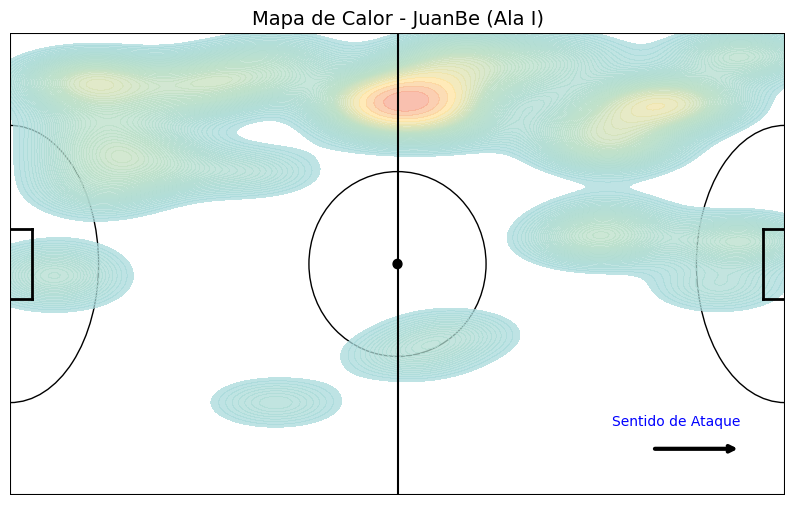

In [10]:
# ---------------------------
# 6. Cargar datos y ejecutar
# ---------------------------
#Montamos el drive de Google
from google.colab import drive
drive.mount('/content/drive/')

# Ruta base donde está el archivo
ruta_base = Path('/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Jugadores')

# Archivo XML específico
xml_file = ruta_base / "Union Ezpeleta - XML NacSport.xml"
df = cargar_datos_nacsport(xml_file)

# Filtrar coordenadas según tipo de evento
df['pos_x_list'], df['pos_y_list'] = zip(*df.apply(filtrar_coords_por_evento, axis=1))
df = df.explode(['pos_x_list', 'pos_y_list']).rename(columns={'pos_x_list': 'pos_x', 'pos_y_list': 'pos_y'})


# Ejecutar para Mateo Pivot
mapa_calor_futsal_horizontal(df, "Bruno", "Ala I")


In [13]:
# =========================
# ÍNDICE COMBINADO POR JUGADOR
# =========================
def indice_combinado_jugador(df_j: pd.DataFrame, modo="eff", w_recu=0.6, w_perd=0.4) -> pd.DataFrame:
    """
    Devuelve df_j con columna 'idx' = w_recu*recuperaciones + w_perd*(1 - pérdidas).
    modo: 'eff'  -> usa %_recuperaciones_sobre_acc_jugador y %_perdidas_sobre_acc_jugador
          'imp'  -> usa %_recuperaciones_sobre_total_zona y %_perdidas_sobre_total_zona
    """
    df = df_j.copy()
    if modo == "imp":
        recu = df["%_recuperaciones_sobre_total_zona"].astype(float).fillna(0)
        perd = df["%_perdidas_sobre_total_zona"].astype(float).fillna(0)
    else:  # 'eff'
        recu = df["%_recuperaciones_sobre_acc_jugador"].astype(float).fillna(0)
        perd = df["%_perdidas_sobre_acc_jugador"].astype(float).fillna(0)

    # Normalización ya está en 0..1; convertimos pérdidas a bondad
    df["idx"] = w_recu * recu + w_perd * (1.0 - perd)
    return df

# Ranking del índice (usa el helper de barras que ya tenés)
def plot_ranking_indice_jugador(df_idx: pd.DataFrame, titulo="Índice combinado (↑ mejor)"):
    orden = df_idx.sort_values("idx", ascending=False)
    labels = [f"Z{z}" for z in orden["zona"]]
    vals   = orden["idx"].to_list()
    tots   = orden["jugador_acciones"].to_list()  # volumen del jugador en esa zona
    fig, ax = plt.subplots(figsize=(8, max(3.2, 0.35*len(labels) + 2)))
    _barh_with_labels(ax, labels, vals, tots, titulo)
    plt.show()


In [14]:
# 1) Resumen por zona del jugador
df_pepo = resumen_por_jugador_zona(df_registros, total_acc, nombre_jugador="Bruno")

# 2) Índice combinado (eficiencia del jugador en la zona)
#df_pepo_idx = indice_combinado_jugador(df_pepo, modo="imp", w_recu=0.6, w_perd=0.4)
df_pepo_idx = indice_combinado_jugador(df_pepo, modo="eff", w_recu=0.6, w_perd=0.4)

# 3) Mapa del índice (↑ mejor) con máscara por volumen del jugador
mat_idx = matriz_from_df_jugador(df_pepo_idx, "idx")
mat_vol_j = matriz_volume_jugador(df_pepo, "jugador_acciones")
plot_mapa_divergente_jugador(
    percent_matrix=mat_idx,
    volumen_jugador_matrix=mat_vol_j,
    title="Bruno — Índice combinado (recuperaciones↑, pérdidas↓)",
    good_high=True,            # índice alto es bueno
    min_actions_player=2
)

# 4) Ranking del índice por zona
plot_ranking_indice_jugador(df_pepo_idx, "PEPO — Índice combinado por zona (↑ mejor)")


NameError: name 'resumen_por_jugador_zona' is not defined